# Import

In [1]:
import math
import os, sys
from typing import Callable, Any, Iterable
from IPython.display import  Markdown, display, display_html

##os.getcwd()
if "../scripts/" not in sys.path:  # to prevent multi adding  
    sys.path.append("../scripts/")
     
import pickle
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from helpers import isnumber, flatten_list_of_dicts
from input_output_plot.printing import output_formatting, display_df_side_by_side
from consts import format, color, del_format, results_dir, pkl_dir

# Load data sets

In [2]:
#X_train_file_small = os.path.join(pkl_dir, 'x_train_features_small.pkl')
X_train_file = os.path.join(pkl_dir, 'x_train_features.pkl')
X_train_addition_file = os.path.join(pkl_dir, 'x_train_addition_features.pkl')
y_train_file = os.path.join(pkl_dir, 'y_train_features.pkl')
X_train_return_file = os.path.join(pkl_dir, 'x_train_return_features.pkl')
x_train_capped_features_file = os.path.join(pkl_dir, 'x_train_capped_features.pkl')
X_test_file = os.path.join(pkl_dir, 'x_test_features.pkl')
X_test_addition_file = os.path.join(pkl_dir, 'x_test_addition_features.pkl')
y_test_file = os.path.join(pkl_dir, 'y_test_features.pkl')
X_test_return_file = os.path.join(pkl_dir, 'x_test_return_features.pkl')

sp500_history_file = os.path.join(pkl_dir, 'sp500_history.pkl')

In [3]:
print(f'Load previously saved data from {pkl_dir}')
with open(X_train_file, 'rb') as fx, open(X_train_addition_file, 'rb') as fxa, open(y_train_file, 'rb') as fy, open(X_train_return_file, 'rb') as fxt, open(x_train_capped_features_file, 'rb') as fxc:
    X_train = pickle.load(fx)
    X_train_addition = pickle.load(fxa)
    y_train = pickle.load(fy)
    X_train_return = pickle.load(fxt)
    X_train_capped = pickle.load(fxc)

with open(X_test_file, 'rb') as fx, open(X_test_addition_file, 'rb') as fxa, open(y_test_file, 'rb') as fy, open(X_test_return_file, 'rb') as fxt:
    X_test = pickle.load(fx)
    X_test_addition = pickle.load(fxa)
    y_test = pickle.load(fy)
    X_test_return = pickle.load(fxt)

with open(sp500_history_file, 'rb') as f:
    sp500_history = pickle.load(f)

Load previously saved data from ../results/pickled


# Cross validation

In [4]:
from input_output_plot.plotting import plot_cv
from model.model_selection import MultiTimeSeriesSplit

## Determine folds sizes

The task's requirement for cross-validation is "the train set has to be bigger than 2 years history". Let determine the number of days in the first 2 years of the train set.

In [5]:
statistic = {}
statistic['n_companies_train'] = len(X_train['Name'].unique())
statistic['n_companies_test'] = len(X_test['Name'].unique())
print(f'Number of companies in the train set: {output_formatting(statistic['n_companies_train'], format)}')
print(f'Number of companies in the test set: {output_formatting(statistic['n_companies_test'], format)}')

Number of companies in the train set: 498
Number of companies in the test set: 505


In [6]:
X_train_dates= X_train.index.unique()
statistic['X_train_dates'] = len(X_train_dates)
print(f'Days in the the train set: {output_formatting(statistic['X_train_dates'], format)}')
days_in_2years_history = len(X_train_dates[(X_train_dates>=X_train_dates.min()) & (X_train_dates<X_train_dates.min()+pd.DateOffset(years=2))])
statistic['days_in_2years_history'] = days_in_2years_history
print(f'Days in the first 2 years of the train set: {output_formatting(statistic['days_in_2years_history'] , format)}')
statistic['X_test_dates'] = len(X_test.index.get_level_values('date').unique())
print(f'Days in the test set: {output_formatting(statistic['X_test_dates'], format)}')

Days in the the train set: 955
Days in the first 2 years of the train set: 504
Days in the test set: 275


Let's take `validation_set_size`=25 and `n_splits`=11. It will cover the whole X_test: 11*25=275 

In [7]:
validation_set_size=25
n_splits=11

In [8]:
# determine the maximum length of the train fold in the first split which let have validation folds to cover the given test set 
max_train_size = statistic['X_train_dates'] - statistic['X_test_dates']
statistic['max_train_size'] = max_train_size
print(f'Maximum size of the train fold in the first split: {output_formatting(max_train_size, format)}')

Maximum size of the train fold in the first split: 680


In [9]:
def is_train_test_folds_have_common_dates(cv, X):
    for tr, tt in cv.split(X=X):
        tr_dates = X.iloc[tr].index.unique()
        tt_dates = X.iloc[tt].index.unique()
        if tr_dates.intersection(tt_dates).size>0:
            return True
    return False

## TimeSeries Split

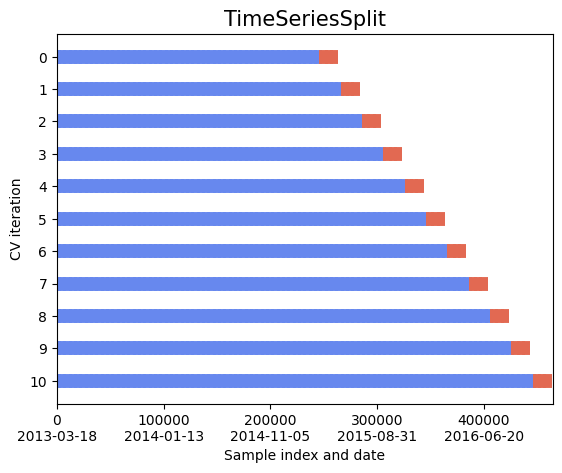

In [10]:
# create a cross-validation object with minimal train set equal 2 years of stock's history + 10 days of stock's history
tscv = MultiTimeSeriesSplit(n_splits=n_splits, 
                            min_train_size=days_in_2years_history+10, 
                            max_train_size=None, 
                            #test_size=validation_set_size, 
                            gap=0)
fig = plot_cv(tscv, 'TimeSeriesSplit', X_train, y_train, scale_x=5000)
display(fig)

This time series split is built with minimum length of train fold according with task requipment (2 years history). Let's get some statistic on it:

In [11]:
statistic['max_days_in_validation_set'] = tscv.get_test_size()
print(f'Length of test (number of days) set in the cross validation showed above: {output_formatting(statistic['max_days_in_validation_set'], format)}')

Length of test (number of days) set in the cross validation showed above: 40


In [12]:
time_series_split_min_train_set = len(X_train)
for train_idxs, _ in tscv.split(X_train):
    time_series_split_min_train_set = min(len(X_train.iloc[train_idxs]), time_series_split_min_train_set)
statistic['samples_in_min_train_set'] = time_series_split_min_train_set
print(f'Length of minimum train fold: {output_formatting(statistic['samples_in_min_train_set'], format)}')

Length of minimum train fold: 248898


Create a cross-validation object with chosen test's length (`25`). Train set is requered to be bigger than `2 years` of stock's history + 10 days of stock's history

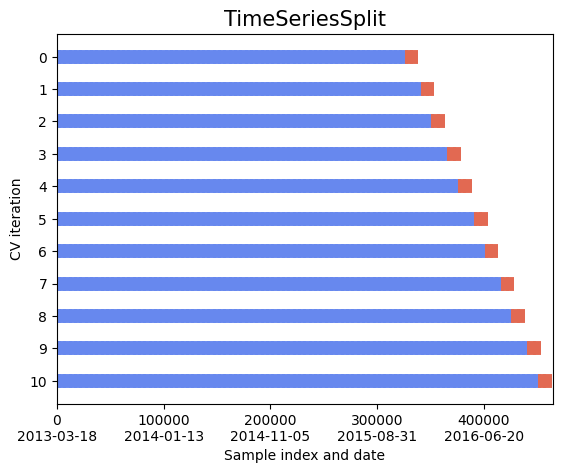

In [13]:
tscv_25 = MultiTimeSeriesSplit(n_splits=n_splits, 
                            min_train_size=days_in_2years_history+10, 
                            max_train_size=None, 
                            test_size=validation_set_size, 
                            gap=0)
fig = plot_cv(tscv_25, 'TimeSeriesSplit', X_train, y_train, scale_x=5000)
display(fig)

In [14]:
print(f'Length of test (number of days) set in the cross validation showed above: {output_formatting(tscv_25.get_test_size(), format)}')
print(f'Minimum length of the train sets (number of days) in the cross-validation above: {output_formatting(tscv_25.get_min_train_size(), format)}')

Length of test (number of days) set in the cross validation showed above: 25
Minimum length of the train sets (number of days) in the cross-validation above: 680


This time the time series split has a train fold with maximum length for the chosen test size.

In [15]:
time_series_split_max_train_set = 0
for train_idxs, _ in tscv_25.split(X_train):
    time_series_split_max_train_set = max(len(X_train.iloc[train_idxs]), time_series_split_max_train_set)
statistic['samples_in_min_train_set'] = time_series_split_max_train_set
print(f'Length of maximum train fold: {output_formatting(statistic['samples_in_min_train_set'], format)}')

Length of maximum train fold: 453962


In [16]:
print(f'Are there data from the same day in the train and test folds : {output_formatting(is_train_test_folds_have_common_dates(tscv, X_train), format)}')

Are there data from the same day in the train and test folds : False


## Blocking TimeSeries Split

In [17]:
tscv_blocking = MultiTimeSeriesSplit(n_splits=n_splits, 
                                     max_train_size=max_train_size, 
                                     min_train_size=days_in_2years_history, 
                                     test_size=validation_set_size, 
                                     gap=0)

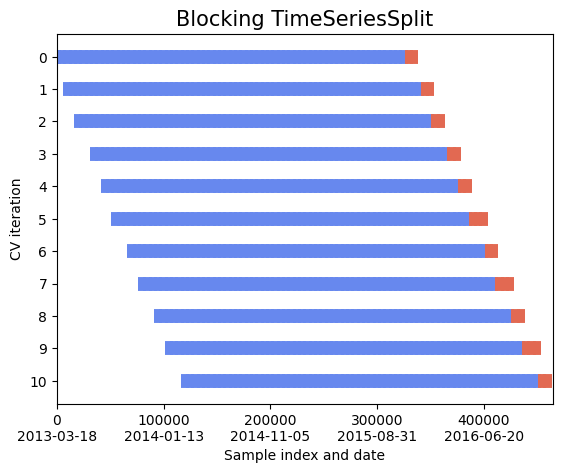

In [18]:
fig = plot_cv(tscv_blocking, 'Blocking TimeSeriesSplit', X_train, y_train, scale_x=5000)
display(fig)

In [19]:
print(f'Minimum length of the train sets {output_formatting('(number of days)',format)} in the cross-validation above: {output_formatting(tscv_blocking.get_min_train_size(), format)}')
print(f'Length of train folds:')
i = 0
end=' -> '
for train_idxs, _ in tscv_blocking.split(X_train):
    if i == n_splits-1:
        end = '\n'
    print(f'{i}: {len(X_train.iloc[train_idxs])}, {len(X_train.iloc[train_idxs]['Name'].unique())}', end=end)
    i += 1

Minimum length of the train sets (number of days) in the cross-validation above: 680
Length of train folds:
0: 329822, 494 -> 1: 330279, 495 -> 2: 330758, 495 -> 3: 331245, 496 -> 4: 331667, 496 -> 5: 332036, 497 -> 6: 332411, 497 -> 7: 332786, 497 -> 8: 333182, 498 -> 9: 333557, 498 -> 10: 333932, 498


In [20]:
print(f'Do the train and test folds contain data from the same day: {output_formatting(is_train_test_folds_have_common_dates(tscv_blocking, X_train), format)}')

Do the train and test folds contain data from the same day: False


In [21]:
print('Statistic:')
print(pd.Series(statistic))

Statistic:
n_companies_train                498
n_companies_test                 505
X_train_dates                    955
days_in_2years_history           504
X_test_dates                     275
max_train_size                   680
max_days_in_validation_set        40
samples_in_min_train_set      453962
dtype: int64


# Model selecting

In [22]:
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, RobustScaler, StandardScaler, MaxAbsScaler, PowerTransformer, KBinsDiscretizer, QuantileTransformer, OrdinalEncoder
from sklearn.decomposition import FastICA, PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, f1_score, recall_score, log_loss, confusion_matrix 

import seaborn as sns

from model.estimating import WrapModelTrainSizeParam, run_classifier_grid_search
from model.validating import cv_scores_on_splits, cv_scores, cv_scores_per_params, create_comparation_table, cv_scores_on_splits_by_param, cv_scores_on_splits_per_param
from input_output_plot.plotting import plot_learning_curves, lineplot, barplot, plot_features_count, plot_validation_curves
from input_output_plot.printing import add_data_frames_to_file


## Functions to build a model

Create a pipline for a model which consists of
- a column transforemer layer
- a model layer, which is a model wrapped by WrapTrainSizeParam class. WrapTrainSizeParam adds the size of train set to the model's parameters.

In [23]:
def make_pipeline(configed_model,column_transformers, configed_dim_reducers=None, train_set_lengths=None):
    # TODO make it work with model instance, not class, WrapModelTrainSizeParam needs to be rewrite in this case
    # TODO add support for transformers parameters, like for dim_redusers 
    params = configed_model['params']
    model_name = configed_model['model'].__name__.lower()

    param_grid =  {f"{model_name}__{param_name}": param_values  for param_name, param_values in params.items()}
    if train_set_lengths is not None:
        param_grid[f"{model_name}__train_length"] = train_set_lengths
        model = WrapModelTrainSizeParam(configed_model['model'])
    else:
        model = configed_model['model']()
    
    if isinstance(column_transformers, list) or isinstance(column_transformers, tuple):
        transformer = "passthrough"
        param_grid["transformer"] = column_transformers
    else:
        transformer = column_transformers
    if configed_dim_reducers is None:
        reducer_dim = "passthrough"
    elif isinstance(configed_dim_reducers, list) or isinstance(configed_dim_reducers, tuple):
        reducer_dim = "passthrough"
        param_grid_exemplar = param_grid
        param_grid = []
        for configed_reducer in configed_dim_reducers:
            r_params = configed_reducer['params']
            r_model = configed_reducer['model']
            param_grid_current = param_grid_exemplar.copy()
            param_grid_current["reduce_dim"] = [r_model]
            for param_name, param_values in r_params.items():
                param_grid_current[f"reduce_dim__{param_name}"] = param_values
            param_grid.append(param_grid_current)
    else:
        reducer_dim = configed_dim_reducers['model']
        for param_name, param_values in configed_dim_reducers['params'].items():
            param_grid[f"reduce_dim__{param_name}"] = param_values

    pipeline = Pipeline([
        ('transformer', transformer),
        ("reduce_dim", reducer_dim), 
        (model_name, model)
        ])
    return {
        'model': pipeline,
        'params':param_grid,
        }


Define metrics to evaluate the performance of the cross-validated model.

In [24]:
scores = ['accuracy', 'average_precision', 'f1', 'roc_auc', 'log_loss']
confusion_matrix_cells = ['tn', 'fp', 'fn', 'tp']
def scorer(clf, X, y):
    y_predict_prob = np.nan
    if hasattr(clf, "predict_proba"):
        y_predict_prob = clf.predict_proba(X)[:, 1]
    if np.isnan(y_predict_prob).any() and hasattr(clf, "decision_function"):
        y_predict_prob = clf.decision_function(X)
    y_pred = np.nan
    y_pred = clf.predict(X)
    if not np.isnan(y_pred).any():
        cm = confusion_matrix(y, y_pred)
        scores = {
            'accuracy': accuracy_score(y,y_pred),
            'f1': f1_score(y,y_pred, average='binary'),
            'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1],
        }
        if not np.isnan(y_predict_prob).any():
            scores['average_precision'] = average_precision_score(y,y_predict_prob)
            scores['roc_auc'] = roc_auc_score(y,y_predict_prob)
            scores['log_loss'] = log_loss(y,y_predict_prob)
        else:
            scores['average_precision'] = np.nan
            scores['roc_auc'] = np.nan
            scores['log_loss'] = np.nan
    else:
        scores = {
            'accuracy': np.nan,
            'average_precision': np.nan,
            'f1': np.nan,
            'roc_auc': np.nan,
            'log_loss': np.nan,
            'tn': np.nan, 'fp': np.nan,
            'fn': np.nan, 'tp': np.nan,
        }
    return scores

`train_classifiers` runs grid search on chosen classifiers and reurns a dictionary with results:  

{  
    'search_time': execution time in sec,  
    'grid_search': fitted GridSearchCV object,  
}

In [25]:
def train_classifiers(results_file, classifiers, column_transformers, configed_dim_reducers=None, train_set_lengths=None, X=X_train, y=y_train, scoring=scorer, cv=tscv_25, return_train_score=True, refit='roc_auc',):
    grid_search_results = []
    models_names = [configed_model['model'].__name__.lower() for configed_model in classifiers]
    def are_keys_in_list(keys, list_):
        for key in keys:
            if key not in list_:
                return False
        return True
    
    if not isinstance(column_transformers, dict) or not are_keys_in_list(models_names, column_transformers.keys()):
        column_transformers = {configed_model['model'].__name__.lower() : column_transformers for configed_model in classifiers}
    if not isinstance(configed_dim_reducers, dict) or not are_keys_in_list(models_names, configed_dim_reducers.keys()):
        configed_dim_reducers = {configed_model['model'].__name__.lower() : configed_dim_reducers for configed_model in classifiers}


    if not os.path.isfile(results_file):
        for configed_model in classifiers:
            model_name = configed_model['model'].__name__.lower()
            print(f'Run grid search on {output_formatting(model_name, format)} classifier')
            print('With', output_formatting('parameters:',format), configed_model['params'])
            print('For', output_formatting('train set lengths:', format), train_set_lengths)
            pipeline = make_pipeline(configed_model, column_transformers[model_name], configed_dim_reducers[model_name], train_set_lengths)
            #print('Pipeline:', pipeline)
            grid_search_result = run_classifier_grid_search(
                pipeline,
                X, y,
                scoring=scoring,
                refit=refit,
                cv=cv,
                return_train_score=return_train_score,
            )
            grid_search_result['name'] = model_name
            grid_search_results.append(grid_search_result)
        
            print('-----------------------------------------------------')
            print(f"Grid search took {output_formatting(grid_search_result['search_time']/60, format)} minutes")
            print(output_formatting('Best parameters:',format), grid_search_result['grid_search'].best_params_)
            print(output_formatting('Best scores:',format), grid_search_result['grid_search'].best_score_)
            print('===================================================================================================================')
        
        with open(results_file, 'wb') as f:
            pickle.dump(grid_search_results, f)
    else:
        print(f'load trained models from {results_file}')
        with open(results_file, 'rb') as f:
            grid_search_results = pickle.load(f)

    return grid_search_results

### Transformers

Transfom the column 'Name' with TargetEncoder.  
Scale numeric columns with Robustscaler, except for indicators where values are only `0` and `1`.  
Scale indicators columns with Standartscaler.

In [26]:
# create a column transformer
cols_indicators = [col for col in X_train.columns if 'indicator' in col]
cols_not_indicators = [col for col in X_train.columns if not ('indicator' in col) and col!='Name']


Create a class for each columns' transforemer to simplify output of GridSearchCV.best_params_, so it will output the name of a class, not the all ColumnTransformer's parameters.

In [27]:
class EncoderNameScalerDigitCols(ColumnTransformer):
    def __init__(self, transformers_columns=None, encoder=TargetEncoder(cv=5), encoder_columns=['Name'], remainder='passthrough',verbose_feature_names_out=True):  
        # transformers_columns is a list of tuples (transformer, columns) specifying the transformer objects to be applied to the columns 
        self.transformers_columns = transformers_columns
        self.encoder_columns = encoder_columns
        self.encoder = encoder
        self.remainder = remainder
        self.verbose_feature_names_out=verbose_feature_names_out
        transformer_sequence = self._make_transformer_tuples()
        super().__init__(transformers=transformer_sequence, remainder=self.remainder, verbose_feature_names_out=self.verbose_feature_names_out)  
        # self.set_output(transform='pandas')
  
    def get_params(self, deep=True):  
        params = super().get_params(deep=deep)
        params['transformers_columns'] = self.transformers_columns 
        params['encoder_columns'] = self.encoder_columns
        params['encoder'] = self.encoder
        params['remainder'] = self.remainder
        return params  
  
    def set_params(self, **params):
        self.transformers_columns = params.pop('transformers_columns',self.transformers_columns)
        self.encoder_columns = params.pop('encoder_columns',self.encoder_columns)
        self.encoder = params.pop('encoder',self.encoder) 
        self.verbose_feature_names_out = params.pop('verbose_feature_names_out', self.verbose_feature_names_out)
        print('set',self.transformers_columns)
        transformer_sequence = self._make_transformer_tuples()
        encoder_columns = self.encoder_columns
        encoder = self.encoder
        verbose_feature_names_out = self.verbose_feature_names_out
        self = ColumnTransformer(transformers=transformer_sequence, remainder=self.remainder, verbose_feature_names_out=self.verbose_feature_names_out)  
        self.encoder_columns = encoder_columns
        self.encoder = encoder
        self.verbose_feature_names_out = verbose_feature_names_out
        super().set_params(**params)
        return self
  
    def _make_transformer_tuples(self):
        #(name, transformer, columns) 
        if self.transformers_columns is None or self.transformers_columns == 'passthrough':
            self.transformers_tuples = [] 
        else:
            self.transformers_tuples = [(transformer.__class__.__name__, transformer, transformer_columns) for transformer, transformer_columns in self.transformers_columns]   
        
        return [
            ('name_encoder', self.encoder, self.encoder_columns),
            *self.transformers_tuples, 
        ]
    

In [28]:
class StanradIndicatorsRobustNotIndicatorsDigitCols(EncoderNameScalerDigitCols):
    def __init__(self, transformers_columns=[(StandardScaler(),cols_indicators),(RobustScaler(),cols_not_indicators)], quantile_range=(25.0, 75.0), encoder=TargetEncoder(cv=5),  encoder_columns=['Name'], remainder='passthrough', verbose_feature_names_out=True):  
        self.quantile_range = quantile_range
        transformers_columns[1][0].set_params(quantile_range=self.quantile_range)
        super().__init__(transformers_columns=transformers_columns, encoder=encoder, encoder_columns=encoder_columns, remainder=remainder, verbose_feature_names_out=verbose_feature_names_out)
  
    def get_params(self, deep=True):  
        params = super().get_params(deep=deep)
        params['quantile_range'] = self.quantile_range 
        return params  
  
    def set_params(self, **params):
        self.quantile_range = params.pop('quantile_range',self.quantile_range)
        self.transformers_columns = params.pop('transformers_columns')
        self.transformers_columns[1][0].set_params(quantile_range=self.quantile_range)
        self = super().set_params(**params)
        return self 

In [29]:
class RobustNotIndicatorsDigitCols(EncoderNameScalerDigitCols):
    def __init__(self, transformers_columns=[(RobustScaler(),cols_not_indicators)], quantile_range=(25.0, 75.0), encoder=TargetEncoder(cv=5), encoder_columns=['Name'], remainder='passthrough', verbose_feature_names_out=True):
        self.quantile_range = quantile_range
        transformers_columns[0][0].set_params(quantile_range=self.quantile_range) # gridsearch gives an error in if the scaler is defined in the constructor (sclalers=RobustScaler(quantile_range=self.quantile_range))
        super().__init__(transformers_columns=transformers_columns, encoder=encoder, encoder_columns=encoder_columns, remainder=remainder, verbose_feature_names_out=verbose_feature_names_out)
  
    def get_params(self, deep=True):  
        params = super().get_params(deep=deep)
        params['quantile_range'] = self.quantile_range 
        return params  
  
    def set_params(self, **params):
        self.quantile_range = params.pop('quantile_range',self.quantile_range)
        self.transformers_columns = params.pop('transformers_columns')
        self.transformers_columns[0].set_params(quantile_range=self.quantile_range)
        self = super().set_params(**params)
        return self  

In [30]:
class NamedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, name):
        self.transformer = transformer
        self.name = name
    def fit(self, X, y=None):
        return self.transformer.fit(X, y)
    def transform(self, X):
        return self.transformer.transform(X)
    def __repr__(self):
        return self.name
    def describe(self):
        return self.__str__()
    def get_feature_names_out(self):
        return self.transformer.get_feature_names_out()

In [31]:
#TODO add BinaryEncoder and 'drop' as encoder
not_indicator_features = [col for col in X_train_capped.columns if col!='Name' and 'indicator' not in col]
standard_scaling_cols = ['rsi', 'cmf']
power_transformer_cols = ['Bollinger_width']
kbins_discretizer_cols = ['Aroon_down', 'Aroon_up']
quantile_transformer_cols = [col for col in not_indicator_features if col not in standard_scaling_cols+power_transformer_cols+kbins_discretizer_cols]

not_indicator_addition_features = [col for col in X_train_addition.columns if col!='Name' and 'indicator' not in col]
power_transformer_addition_cols = ['keltner_channel_width', 'ulcer_index']
kbins_discretizer_addition_cols = ['Aroon_ind']
quantile_transformer_addition_cols = [col for col in not_indicator_addition_features if col not in power_transformer_addition_cols+kbins_discretizer_addition_cols]

std_scaler = StandardScaler() 
max_abs_scaler = MaxAbsScaler()
power_transforemer = PowerTransformer(method='yeo-johnson')
kbins_uniform = KBinsDiscretizer(n_bins=10, strategy='uniform')
kbins_quantile = KBinsDiscretizer(n_bins=10, strategy='quantile')
quantile_transformer = QuantileTransformer(output_distribution='normal')
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=555)
target_encoder = TargetEncoder(cv=5)
encoders = [ordinal_encoder, target_encoder, 'drop']
encoders_names=['ordinal', 'target', 'drop']
column_transformers = {}
for encoder_name, encoder in zip(encoders_names, encoders):
    column_transformers[f'{encoder_name}_std_quantile_power_kbins_u'] = NamedTransformer(name=f'{encoder_name}_std_quantile_power_kbins_u', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols), 
                                                            (kbins_uniform, kbins_discretizer_cols), 
                                                            (quantile_transformer, quantile_transformer_cols)], 
                                                    encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_std_quantile_power_kbins_q'] = NamedTransformer(name=f'{encoder_name}_std_quantile_power_kbins_q', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols), 
                                                            (kbins_quantile, kbins_discretizer_cols), 
                                                            (quantile_transformer, quantile_transformer_cols)], 
                                                    encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_quantile_power_kbins_u'] = NamedTransformer(name=f'{encoder_name}_quantile_power_kbins_u', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                        (kbins_uniform, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_quantile_power_kbins_q'] = NamedTransformer(name=f'{encoder_name}_quantile_power_kbins_q', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                        (kbins_quantile, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_quantile_power'] = NamedTransformer(name=f'{encoder_name}_quantile_power', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(power_transforemer, power_transformer_cols),
                                                    (quantile_transformer, quantile_transformer_cols)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_no_transform_digit_cols'] = NamedTransformer(name=f'{encoder_name}_no_transform_digit_cols', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=None,
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_max_abs_not_indicators'] = NamedTransformer(name=f'{encoder_name}_max_abs_not_indicators', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(max_abs_scaler,cols_not_indicators)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

    column_transformers[f'{encoder_name}_standard_not_indicators'] = NamedTransformer(name=f'{encoder_name}_standard_not_indicators', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,cols_not_indicators)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

    column_transformers[f'{encoder_name}_standard'] = NamedTransformer(name=f'{encoder_name}_standard', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,[*cols_not_indicators, *cols_indicators])], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_standard_robust'] = NamedTransformer(name=f'{encoder_name}_standard_robust', 
                                    transformer=StanradIndicatorsRobustNotIndicatorsDigitCols(encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_robust_not_indicators'] = NamedTransformer(name=f'{encoder_name}_robust_not_indicators', 
                                    transformer=RobustNotIndicatorsDigitCols(encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

from category_encoders.binary import BinaryEncoder
encoders_lots_features = [BinaryEncoder()]
encoders_names_lots_features=['binary']
kbins_uniform_dense = KBinsDiscretizer(n_bins=20, strategy='uniform', encode='onehot-dense')
kbins_quantile_dense = KBinsDiscretizer(n_bins=20, strategy='quantile', encode='onehot-dense')
column_transformers_lots_features = {}
for encoder_name, encoder in zip(encoders_names_lots_features, encoders_lots_features):
    column_transformers_lots_features[f'{encoder_name}_std_quantile_power_kbins_u'] = NamedTransformer(name=f'{encoder_name}_std_quantile_power_kbins_u', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols), 
                                                            (kbins_uniform, kbins_discretizer_cols), 
                                                            (quantile_transformer, quantile_transformer_cols)], 
                                                    encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_std_quantile_power_kbins_q'] = NamedTransformer(name=f'{encoder_name}_std_quantile_power_kbins_q', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols), 
                                                            (kbins_quantile, kbins_discretizer_cols), 
                                                            (quantile_transformer, quantile_transformer_cols)], 
                                                    encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_quantile_power_kbins_u'] = NamedTransformer(name=f'{encoder_name}_quantile_power_kbins_u', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                        (kbins_uniform, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_quantile_power_kbins_q'] = NamedTransformer(name=f'{encoder_name}_quantile_power_kbins_q', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                        (kbins_quantile, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_quantile_power'] = NamedTransformer(name=f'{encoder_name}_quantile_power', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(power_transforemer, power_transformer_cols),
                                                    (quantile_transformer, quantile_transformer_cols)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_non_scale_digit_cols'] = NamedTransformer(name=f'{encoder_name}_non_scale_digit_cols', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=None, 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_max_abs_not_indicators'] = NamedTransformer(name=f'{encoder_name}_max_abs_not_indicators', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(max_abs_scaler,cols_not_indicators)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

    column_transformers_lots_features[f'{encoder_name}_standard_not_indicators'] = NamedTransformer(name=f'{encoder_name}_standard_not_indicators', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,cols_not_indicators)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_standard'] = NamedTransformer(name=f'{encoder_name}_standard', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,[*cols_not_indicators, *cols_indicators])], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_standard_robust'] = NamedTransformer(name=f'{encoder_name}_standard_robust', 
                                    transformer=StanradIndicatorsRobustNotIndicatorsDigitCols(encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_robust_not_indicators'] = NamedTransformer(name=f'{encoder_name}_robust_not_indicators', 
                                    transformer=RobustNotIndicatorsDigitCols(encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

    column_transformers_lots_features[f'{encoder_name}_uniform'] = NamedTransformer(name=f'{encoder_name}_uniform', 
                                                                      transformer=EncoderNameScalerDigitCols(
                                                                          transformers_columns=[(kbins_uniform_dense, cols_not_indicators)], 
                                                                          encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_quantile'] = NamedTransformer(name=f'{encoder_name}_quantile', 
                                                                      transformer=EncoderNameScalerDigitCols(
                                                                          transformers_columns=[(kbins_quantile_dense, cols_not_indicators)], 
                                                                          encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')


### Functions for analyzing results 

In [ ]:
score_file = os.path.join(results_dir,'ml_metrics_train.md')
accuracy_roc_file = os.path.join(results_dir,'ml_metrics_train_accuracy_roc.md')

def create_tables_of_best_scores(grid_search_results):
    for grid_search_result in grid_search_results:
        grid_search_result['scores_on_splits'], grid_search_result['best_estimator_scores'] = \
            cv_scores_on_splits(grid_search_result['grid_search'],scores=scores,confusion_matrix_cells=confusion_matrix_cells,n=2)
        
def save_scores_of_stage_to_file(grid_search_results, stage, file_path=score_file):
    create_tables_of_best_scores(grid_search_results)
    with open(file_path, 'a', encoding='utf-8') as f: 
        f.write(f'\n\n## Stage: {stage} \n')

    scores_dfs = {f"{grid_search_result['name']}\n({grid_search_result['grid_search'].best_params_})\ntime: {grid_search_result['search_time']/60} min\n":
              grid_search_result['best_estimator_scores'] for grid_search_result in grid_search_results}
    add_data_frames_to_file(file_path, scores_dfs)

In [ ]:
key_results_file = os.path.join(results_dir, 'key_results.md')
    
def save_grid_search_key_results(grid_search_results, stage, file_path=key_results_file):
    with open(file_path, 'a', encoding='utf-8') as f: 
        f.write(f'\n\n## Stage: {stage} \n')
        for grid_search_result in grid_search_results:
            param_grid = flatten_list_of_dicts(grid_search_result["grid_search"].param_grid)
             
            grid_search_result['key_results'] = pd.Series([
                param_grid, 
                grid_search_result["grid_search"].best_params_, 
                grid_search_result["grid_search"].best_score_, 
                grid_search_result["search_time"]/60],
                index=['Parameters grid', 'Best parameters', 'Best scores', 'Search time(min)'
            ])
            f.write(f'\n\n### {grid_search_result["name"]}\n')
            f.write(grid_search_result['key_results'].to_markdown())
            f.write('\n------------------------------------------------------------------------------------------------------')
    print(f'--- data is saved to {file_path} ---')

In [ ]:
def concatenate_estimators_scores(grid_search_results, score_key='best_estimator_scores'):
    dfs = []
    for grid_search_result in grid_search_results:
        df = grid_search_result[score_key].copy()
        df['Model name'] = grid_search_result['name']
        dfs.append(df)
    return pd.concat(dfs)

In [ ]:
def create_tables_of_scores_by_param(grid_search_results, par_names, key, score='roc_auc'):
    def define_param_name(grid_search_result, par_name):
        if par_name in flatten_list_of_dicts(grid_search_result['grid_search'].param_grid):
            return par_name
        else:
            return f'{grid_search_result["name"]}__{par_name}'
        
    def get_best_params_value(grid_search_result, param_name):
        best_params_ = grid_search_result['grid_search'].best_params_
        if param_name not in best_params_:
            return "-"
        sub_params = {name_.split('__')[-1]: value for name_, value in best_params_.items() if f'{param_name}__' in name_}
        if not sub_params:
            res_str =  f"{best_params_[param_name]}"
        else:
            res_str =  f"{best_params_[param_name]} ({sub_params})"
        return res_str

    best_params = {}
    for grid_search_result in grid_search_results:
        model_name = grid_search_result['name']
        if isinstance(par_names, str):
            param_name = define_param_name(grid_search_result, par_names)
            grid_search_result[key] = cv_scores(grid_search_result['grid_search'], score=score, par_names=param_name)
            best_params[model_name] = get_best_params_value(grid_search_result, param_name)
        else:
            param_names = [define_param_name(grid_search_result, par_name) for par_name in par_names]
            grid_search_result[key] = cv_scores_per_params(grid_search_result['grid_search'], score=score, par_names=param_names)
            best_params[model_name] = {par_name: get_best_params_value(grid_search_result, par_name) for par_name in param_names}

    
    res_df = concatenate_estimators_scores(grid_search_results, score_key=key)
    
    return res_df, best_params

def print_scores_by_param(res_df, best_params, title, score='roc_auc', param_values_prune=None, model_names_prune=None ):
    print(f'****Splitwise mean of {color}{score}{del_format} scores for each {title} and the best value for the other parametrs****\n')
    for model_name, best_param in best_params.items():
        print(f"Best parameters: {output_formatting(model_name, format)}: {best_param}")
    print('\n========================================================================================================')

    to_print_df = res_df.pivot(columns='Model name').swaplevel(axis='columns').sort_index(axis='columns', level=0, sort_remaining=False)
    to_print_df = to_print_df.rename(columns=lambda x: x[:model_names_prune], level='Model name')
    to_print_df = to_print_df.rename(index=lambda x: x[:param_values_prune] if isinstance(x, str) else x)
    print(to_print_df)

In [ ]:
def plot_validation_by(df_to_plot, by, score_to_plot='roc_auc', hue='Model name', figsize=(11, 4), rotation_ticks=False):
    value_vars=['train', 'test']
    id_vars=[c for c in df_to_plot.columns if c not in value_vars]
    df_to_plot = df_to_plot.melt(id_vars=id_vars, value_vars=value_vars, var_name='set', value_name=score_to_plot)
    snsplot = lineplot(df_to_plot, x=by,  y=score_to_plot, style='set', hue=hue, title=f'{score_to_plot} by {by}s', figsize=figsize, rotation_ticks=rotation_ticks) 
    return snsplot

plot of ROC_AUC scores are saved into  ../results/roc_auc_t_r.pdf


## GridSearch with more features( RandomForestClassifier )

In [87]:
X_train_big = pd.concat([X_train, X_train_addition], axis=1)
be = BinaryEncoder()
column_transformers_bin_big = NamedTransformer(name=f'binary_std_quantile_power_kbins_q', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols+power_transformer_addition_cols), 
                                                            (kbins_quantile, kbins_discretizer_cols+kbins_discretizer_addition_cols), 
                                                            (quantile_transformer, quantile_transformer_cols+quantile_transformer_addition_cols),], 
                                                    encoder=be, verbose_feature_names_out=False
                )).set_output(transform='pandas')
column_transformers_ord_big = NamedTransformer(name=f'order_std_quantile_power_kbins_q', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols+power_transformer_addition_cols), 
                                                            (kbins_quantile, kbins_discretizer_cols+kbins_discretizer_addition_cols), 
                                                            (quantile_transformer, quantile_transformer_cols+quantile_transformer_addition_cols),], 
                                                    encoder=ordinal_encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

### Classifiers and hyperparameters.

In [88]:
configer_classifier_rf2=[
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators': [200],# 250],
            #'min_samples_split': [2], 2- default 
            'min_samples_leaf': [5],#6], 
            'max_features': [None],
            'max_depth': [5],
        }
    },
]
X_train_big = pd.concat([X_train, X_train_addition[X_train_addition.columns.difference(['Name'])]], axis=1)
be = BinaryEncoder()
column_transformers_bin_big = NamedTransformer(name=f'binary_std_quantile_power_kbins_q', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols+power_transformer_addition_cols), 
                                                            (kbins_quantile, kbins_discretizer_cols+kbins_discretizer_addition_cols), 
                                                            (quantile_transformer, quantile_transformer_cols+quantile_transformer_addition_cols),], 
                                                    encoder=be, verbose_feature_names_out=False
                )).set_output(transform='pandas')
column_transformers_ord_big = NamedTransformer(name=f'order_std_quantile_power_kbins_q', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols+power_transformer_addition_cols), 
                                                            (kbins_quantile, kbins_discretizer_cols+kbins_discretizer_addition_cols), 
                                                            (quantile_transformer, quantile_transformer_cols+quantile_transformer_addition_cols),], 
                                                    encoder=ordinal_encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

column_transformers_rf2 = [column_transformers_ord_big, column_transformers_bin_big]
dim_reducers_rf2 = {'model': FastICA(), 'params': {'n_components': [2,4,6,8,None]}}
train_set_lengths_rf2 = [265602, 300462]

In [89]:
n_orgs_half = 250
one_day_samples_half = resample(X_train[X_train.index=='2013-04-04'], n_samples=n_orgs_half, replace=False, stratify=y_train[X_train.index=='2013-04-04'])
sample_orgs = one_day_samples_half['Name']
X_train_big_half = X_train_big[X_train_big['Name'].isin(sample_orgs)]
y_train_half = y_train[X_train_big['Name'].isin(sample_orgs)]

### GridSearch

In [90]:
results_file_rf2= os.path.join(pkl_dir,'prediction_results_rf2.pkl' )#'selected_model.pkl'
grid_search_results_rf2 = train_classifiers(results_file=results_file_rf2,
                                         classifiers=configer_classifier_rf2,
                                         column_transformers=column_transformers_rf2,
                                         configed_dim_reducers=dim_reducers_rf2,
                                         train_set_lengths=train_set_lengths_rf2, 
                                         X=X_train_big, y=y_train, 
                                         scoring=scorer, 
                                         cv=tscv_blocking,
)

load trained models from ../results/pickled\prediction_results_rf2.pkl


### Analyze results

In [92]:
save_grid_search_key_results(grid_search_results_rf2, "Choose RandomForestClassifier's hyperparameters")
save_scores_of_stage_to_file(grid_search_results_rf2, "Choose RandomForestClassifier's hyperparameters")

--- data is saved to ../results/key_results.md ---
Saving randomforestclassifier
({'randomforestcl...
--- data is saved to ../results/ml_metrics_train.md ---


In [93]:
with open(accuracy_roc_file, 'a', encoding='utf-8') as f: 
    f.write("## Choose RandomForestClassifier's hyperparameters \n")
accuracy_dfs = {}
roc_auc_dfs = {}
split7_9 = {}
top_scores = {}
for grid_search_result in grid_search_results_rf2:
    name_ = grid_search_result['name']
    sets = grid_search_result['scores_on_splits'].index.get_level_values('set')
    accuracy_dfs[name_] = grid_search_result['scores_on_splits']['accuracy'][sets=='test'].dropna(how='all') 
    roc_auc_dfs[name_] = grid_search_result['scores_on_splits']['roc_auc'][sets=='test'].dropna(how='all')
    splits = grid_search_result['scores_on_splits'].index.get_level_values('split')
    split7_9[name_] = grid_search_result['scores_on_splits'][['accuracy','roc_auc']][(splits=='split7')|(splits=='split9')].dropna(how='all')
    top_scores[name_] = pd.concat([accuracy_dfs[name_].nlargest(5,keep='all'),roc_auc_dfs[name_].nlargest(5,keep='all')], axis='columns')
    top_scores[name_] = pd.concat([top_scores[name_],split7_9[name_]], axis='index')
#for model, df in top_scores.items():
    #print(f"Top scores for {model}:")
    #display(df)
add_data_frames_to_file(accuracy_roc_file, top_scores)

Saving randomforestclassifier...
--- data is saved to ../results/ml_metrics_train_accuracy_roc.md ---


In [94]:
results_file_rf= os.path.join(pkl_dir,'prediction_results_rf.pkl' )#'selected_model.pkl'
grid_search_results_rf = pickle.load(open(results_file_rf, 'rb'))
comparation_table = create_comparation_table([grid_search_results_rf, grid_search_results_rf2],
                          ['RFC', 'RFC_add_features'],
                          ['randomforestclassifier',], 
                          ['score', 'transformer', 'reduce_dim', 'reduce_dim__n_components'])
comparation_table#[comparation_table['diff'] != 'Same']

RFC  \
model                  param                                                
randomforestclassifier max_depth_best                                   3   
                       max_depth_grid                           [3, 4, 5]   
                       max_features_best                             None   
                       max_features_grid                           [None]   
                       min_samples_leaf_best                            5   
                       min_samples_leaf_grid                    [3, 5, 6]   
                       n_estimators_best                              250   
                       n_estimators_grid                  [200, 250, 300]   
                       reduce_dim                                     NaN   
                       reduce_dim__n_components                         2   
                       score                                     0.530291   
                       train_length_best                           265602   
                       train_length_grid         [265602, 280210, 300462]   
                       transformer                                    NaN   

                                                                 RFC_add_features  \
model                  param                                                        
randomforestclassifier max_depth_best                                           5   
                       max_depth_grid                                         [5]   
                       max_features_best                                     None   
                       max_features_grid                                   [None]   
                       min_samples_leaf_best                                    5   
                       min_samples_leaf_grid                                  [5]   
                       n_estimators_best                                      200   
                       n_estimators_grid                                    [200]   
                       reduce_dim                                             NaN   
                       reduce_dim__n_components                                 2   
                       score                                             0.526688   
                       train_length_best                                   300462   
                       train_length_grid                         [265602, 300462]   
                       transformer               order_std_quantile_power_kbins_q   

                                                      diff  
model                  param                                
randomforestclassifier max_depth_best                   --  
                       max_depth_grid                   --  
                       max_features_best              Same  
                       max_features_grid              Same  
                       min_samples_leaf_best          Same  
                       min_samples_leaf_grid            --  
                       n_estimators_best                --  
                       n_estimators_grid                --  
                       reduce_dim                     Same  
                       reduce_dim__n_components       Same  
                       score                     Best: RFC  
                       train_length_best                --  
                       train_length_grid                --  
                       transformer                      --

In [95]:
train_length_comparation, best_train_length = create_tables_of_scores_by_param(grid_search_results_rf2, par_names='train_length', key='scores_by_train_length')
print_scores_by_param(train_length_comparation, best_train_length, 'train_length', model_names_prune=10)

****Splitwise mean of roc_auc scores for each train_length and the best value for the other parametrs****

Best parameters: randomforestclassifier: 300462

Model name randomfore          
                train      test
265602       0.523440  0.526445
300462       0.523147  0.526688


In [96]:
reducer_comparation, best_reducer = create_tables_of_scores_by_param(grid_search_results_rf2, par_names='reduce_dim__n_components', key='scores_by_dim_reducers')
print_scores_by_param(reducer_comparation, best_reducer, 'dimention reducer', model_names_prune=10)

****Splitwise mean of roc_auc scores for each dimention reducer and the best value for the other parametrs****

Best parameters: randomforestclassifier: 2

Model name randomfore          
                train      test
2            0.523147  0.526688
4            0.525789  0.520278
6            0.531557  0.515034
8            0.532440  0.517025
None         0.542177  0.511661


In [97]:
transformer_comparation, best_transformer = create_tables_of_scores_by_param(grid_search_results_rf2, par_names='transformer', key='scores_by_transformer')
print_scores_by_param(transformer_comparation, best_transformer, 'transformer', model_names_prune=10)

****Splitwise mean of roc_auc scores for each transformer and the best value for the other parametrs****

Best parameters: randomforestclassifier: order_std_quantile_power_kbins_q

Model name                        randomfore          
                                       train      test
binary_std_quantile_power_kbins_q   0.523991  0.522975
order_std_quantile_power_kbins_q    0.523147  0.526688


In [98]:
rocauc_by_splits_rf2_file = os.path.join(results_dir,'roc_auc_rf_addition_features.pdf')
# plot by splits
snsplot_split = lineplot(concatenate_estimators_scores(grid_search_results_rf2), x='split',  y='roc_auc',style='set',title='Compare ROC_AUC of the best models', figsize=(11, 4)) 

#plot by transformer
by='transformer'
df_to_plot = transformer_comparation.reset_index(names=by)
snsplot_transformer = plot_validation_by(df_to_plot, by=by) 
#plot by min_samples_leaf
by='reduce_dim__n_components'
df_to_plot = reducer_comparation.reset_index(names=by)
df_to_plot[by]= df_to_plot['reduce_dim__n_components'].astype(str).str.split(' ').str[-1]
snsplot_reducer_comparation = plot_validation_by(df_to_plot, by=by) 
#plot by train_length
by='train_length'
df_to_plot = train_length_comparation.reset_index(names=by)
snsplot_train_length = plot_validation_by(df_to_plot, by=by) 
with PdfPages(rocauc_by_splits_rf2_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    snsplot_transformer.figure.savefig(pdf, format='pdf')
    snsplot_reducer_comparation.figure.savefig(pdf, format='pdf')
    snsplot_train_length.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', output_formatting(rocauc_by_splits_rf2_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_rf_addition_features.pdf
